In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
tow = pd.read_excel('tow.xlsx')
tow.columns = map(str.lower, tow.columns)
tow.columns = tow.columns.str.replace(' ', '_')
tow.columns = tow.columns.str.replace('?', '')
faction_replace = {'Warriors of Chaos': 'W_Chaos', 'Tomb Kings of Khemri': 'Tomb_Kings', 'Kingdom of Bretonnia': 'Bretonnia', 'Ogre Kingdoms': 'Ogres', 'Wood Elf Realms': 'Wood_Elves', 'Dwarfen Mountain Holds': 'Dwarves', 'Orc and Goblin Tribes': 'O&G', 'Empire of Man': 'Empire', 'Beastmen Brayherds': 'Beastmen', 'High Elf Realms': 'High_Elves', 'Daemons of Chaos': 'D_Chaos', 'Vampire Counts': 'Vampire_Counts', 'Dark Elves':'Dark_Elves', 'Chaos Dwarfs': 'Chaos_Dwarves'}
result_replace = {1:0.5, 2:1}
tow.replace({'player1_faction':faction_replace}, inplace=True)
tow.replace({'player2_faction':faction_replace}, inplace=True)
tow.replace({'player1_result': result_replace}, inplace=True)
tow.replace({'player2_result': result_replace}, inplace=True)

# Warhammer: The Old World
## A Statistical Analysis of Tournament Win Rates
### By: Jacob M. Lundeen

I was first introduced to Games Workshop's (GW) Warhammer: Fantasy Battles (WFB) back in the mid 1990's in Fairfax, Virginia. I was in the fifth or sixth grade and wondered by a GW store with my parents. I convinced them to take me in and managed to walk out with my first eight pack of skeleton warriors (Undead for life!). Over the next couple of years I would acquire a healthy collection of miniatures that was significantly boosted by my winning a White Dwarf survey contest and bringing home $5k worth of Tyranids, Dogs of War, Blood Bowl, and a others. As I grew up, I lost interest in WFB for various reasons as a lot of kids do. However, with WFB being reborn as Warhammer: The Old World (TOW) earlier this year, and me as an adult able to afford this hobby, I jumped back in and haven't looked back.

Since I've rediscovered TOW, I've wanted to combine TOW with one of my other passions, Data Science. With TOW only having returned earlier this year, the available data set is still immature. As we'll see there are many instances of incredible small sample sizes when we look at specific faction versus faction. But my hope is this will give an interesting look into where the game currently stands, where it might need to go, and lead to other interesting questions to ask and explore.

## The Data
The data I am using comes from the Woehammer website (woehammer.com). They compiled their dataset by scraping several tournament tracking websites such as Best Coast Pairings (bestcoastpairings.com). Tournaments use these websites to manage and track their results. I've already done the intial cleaning of the dataset, getting the column names correct and replacing the faction names with shorter names for ease of reading.

In [3]:
tow.shape

(2030, 31)

In [4]:
tow.head()

,pairing_id,round,player1_name,player2_name,player1_result,player2_result,player1_score,player2_score,event_name,event_date,...,points,rounds,ruleset,full_data,mirror_match,players,legacy_lists,allies,rule_of_3,faction_v_faction
0,405136,1,Ridvan Martinez,David Clarke,1.0,0.0,1770.0,901.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,N,N,12,Y,NaN,NaN,Wood Elf Realms
1,405155,1,Mike Summerfeldt,Russ Jeffery,0.0,1.0,450.0,1920.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Warriors of ChaosWood Elf Realms
2,405171,1,Brandon Deamer,Eddie Crampton,1.0,0.0,1745.0,1531.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Tomb Kings of KhemriHigh Elf Realms
3,405192,1,taylor hanson,Luka Pavicevic,0.0,1.0,867.0,1205.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Kingdom of BretonniaDwarfen Mountain Holds
4,405199,1,Eric Locke,Danny Stewart,0.0,1.0,815.0,1206.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,N,N,12,Y,NaN,NaN,Ogre Kingdoms


So we currently have 2020 entries and 31 variables. We are not interested in all of these variables, I'll primarily be looking at player1_result, player2_result, player1_faction, player2_faction, points, and ruleset. The dataset also has two columns, full_data and mirror_match, that will help us filter for the data we want. The former identifies any match where one or both of the players have missing data (name, result, faction) and the latter is if the same faction plays against itself which will be excluded from analysis.

In [5]:
tow = tow.query("`mirror_match` == 'N' & full_data == 'Y'")
tow.shape

(1616, 31)

With the initial filtering done, we stand at 1616 samples. However, each sample contains the data for both players. To be able to do any analysis, we need to transform the dataset so each sample pertains to a single player's (or for our focus faction's) result.

In [6]:
player1_db = tow[['player1_faction', 'player2_faction' ,'player1_result', 'points', 'rounds', 'ruleset', 'players']].rename(columns={"player1_faction": "player_faction", "player2_faction" : "opponent_faction", "player1_result" : "result"})
player2_db = tow[['player2_faction', 'player1_faction', 'player2_result', 'points', 'rounds', 'ruleset', 'players']].rename(columns={"player2_faction": "player_faction", "player1_faction" : "opponent_faction", "player2_result" : "result"})
player_db = pd.concat([player1_db, player2_db], ignore_index=True)
display(player_db)

,player_faction,opponent_faction,result,points,rounds,ruleset,players
0,W_Chaos,Wood_Elves,0.0,2000,3,v1.1,12
1,Tomb_Kings,High_Elves,1.0,2000,3,v1.1,12
2,Bretonnia,Dwarves,0.0,2000,3,v1.1,12
3,Ogres,Dwarves,1.0,2000,3,v1.1,12
4,Wood_Elves,Tomb_Kings,1.0,2000,3,v1.1,12
...,...,...,...,...,...,...,...
3227,High_Elves,Dark_Elves,1.0,1250,3,v1.2,10
3228,Bretonnia,Skaven,0.0,1250,3,v1.2,10
3229,Tomb_Kings,Ogres,1.0,1250,3,v1.2,10
3230,O&G,D_Chaos,0.0,1250,3,v1.2,10


There we go, 3232 samples with 7 variables. The dataset is now ready for us to start diving into.

In [7]:
player_db.groupby(['player_faction', 'opponent_faction']).count()

result  points  rounds  ruleset  players
player_faction opponent_faction                                          
Beastmen       Bretonnia             25      25      25       25       25
               Chaos_Dwarves          3       3       3        3        3
               D_Chaos                1       1       1        1        1
               Dark_Elves             2       2       2        2        2
               Dwarves               10      10      10       10       10
...                                 ...     ...     ...      ...      ...
Wood_Elves     Ogres                  5       5       5        5        5
               Skaven                 8       8       8        8        8
               Tomb_Kings            22      22      22       22       22
               Vampire_Counts         8       8       8        8        8
               W_Chaos               26      26      26       26       26

[234 rows x 5 columns]

## Analysis
### Baseline
We will start with establishing a baseline from where we can compare the rest of the analyses. So we will look at the win rates for all factions regardless of point size, tournament length, etc. Also, ties will be counted as half a win.

In [8]:
tow_faction_wr = player_db.groupby(['player_faction'])['opponent_faction'].count().reset_index()
wins_db = player_db.query("result != 0.0").groupby(['player_faction'])['result'].sum().reset_index()
tow_faction_wr['wins'] = wins_db['result']
tow_faction_wr.rename(columns={'opponent_faction':'games_played'}, inplace=True)
tow_faction_wr['win_rate'] = tow_faction_wr['wins'] / tow_faction_wr['games_played']
tow_faction_wr['points'] = 'all'
tow_faction_wr = tow_faction_wr[list(('player_faction', 'points', 'games_played', 'wins', 'win_rate'))]
tow_faction_wr

,player_faction,points,games_played,wins,win_rate
0,Beastmen,all,163,85.0,0.521472
1,Bretonnia,all,378,206.0,0.544974
2,Chaos_Dwarves,all,59,29.0,0.491525
3,D_Chaos,all,89,42.0,0.471910
4,Dark_Elves,all,137,63.0,0.459854
5,Dwarves,all,258,115.5,0.447674
6,Empire,all,240,92.0,0.383333
7,High_Elves,all,222,120.0,0.540541
8,Lizardmen,all,84,37.5,0.446429
9,O&G,all,320,164.0,0.512500


So what do we see here: four factions have less than one hundred games played and every faction has at least twenty-nine wins. Four factions have over three hundred games played. Of the sixteen factions, five have win rates outside the accepted "sweet spot" of 45-55%, all of which are under 45%.

### Win Rate by Points
Now that the baseline has been established, we can start to dive deeper into the data to see what we can find. The first dive is going to look at win rates when point sizes are accounted for. The first thing we do will determine the three most popular points sizes.

In [9]:
player_db.groupby(['points'])['player_faction'].count().sort_values(ascending=False).reset_index()

,points,player_faction
0,2000,1672
1,1500,836
2,1250,334
3,1999,128
4,1000,110
5,1750,106
6,2500,30
7,2250,10
8,500,6


We see the three most popular point sizes are 2000, 1500, and 1250. So now we need to transform our dataset, so we can perform the statistical analysis. We've already calculated the win rate by faction for all point sizes, so we just need to calculate the win rate by point size and then join the two datasets on player_faction and points to get our final dataset.

In [10]:
tow_points_wr = player_db.groupby(['player_faction', 'points'])['opponent_faction'].count().reset_index()
tow_points_wins = player_db.query("result != 0.0").groupby(['player_faction', 'points'])['result'].sum().reset_index()
tow_points_wr = tow_points_wr.merge(tow_points_wins, left_on=['player_faction', 'points'], right_on=['player_faction', 'points'], how='left')
tow_points_wr.rename(columns={'opponent_faction':'games_played', 'result':'wins'}, inplace=True)
tow_points_wr['win_rate'] = tow_points_wr['wins'] / tow_points_wr['games_played']
tow_points_wr = pd.concat([tow_points_wr, tow_faction_wr], ignore_index=True).sort_values(by=['player_faction', 'points']).dropna().reset_index(drop=True)
tow_points_wr['points'] = tow_points_wr['points'].astype(str)
tow_points_wr

,player_faction,points,games_played,wins,win_rate
0,Beastmen,1250,16,8.0,0.500000
1,Beastmen,1500,49,18.5,0.377551
2,Beastmen,1750,14,8.5,0.607143
3,Beastmen,1999,2,1.0,0.500000
4,Beastmen,2000,82,49.0,0.597561
...,...,...,...,...,...
110,Wood_Elves,1750,7,4.5,0.642857
111,Wood_Elves,1999,11,4.5,0.409091
112,Wood_Elves,2000,111,57.0,0.513514
113,Wood_Elves,2250,2,2.0,1.000000


With our dataset built, it's time to dive in. We will start by plotting the win rates and see what patterns we might be able to discern.

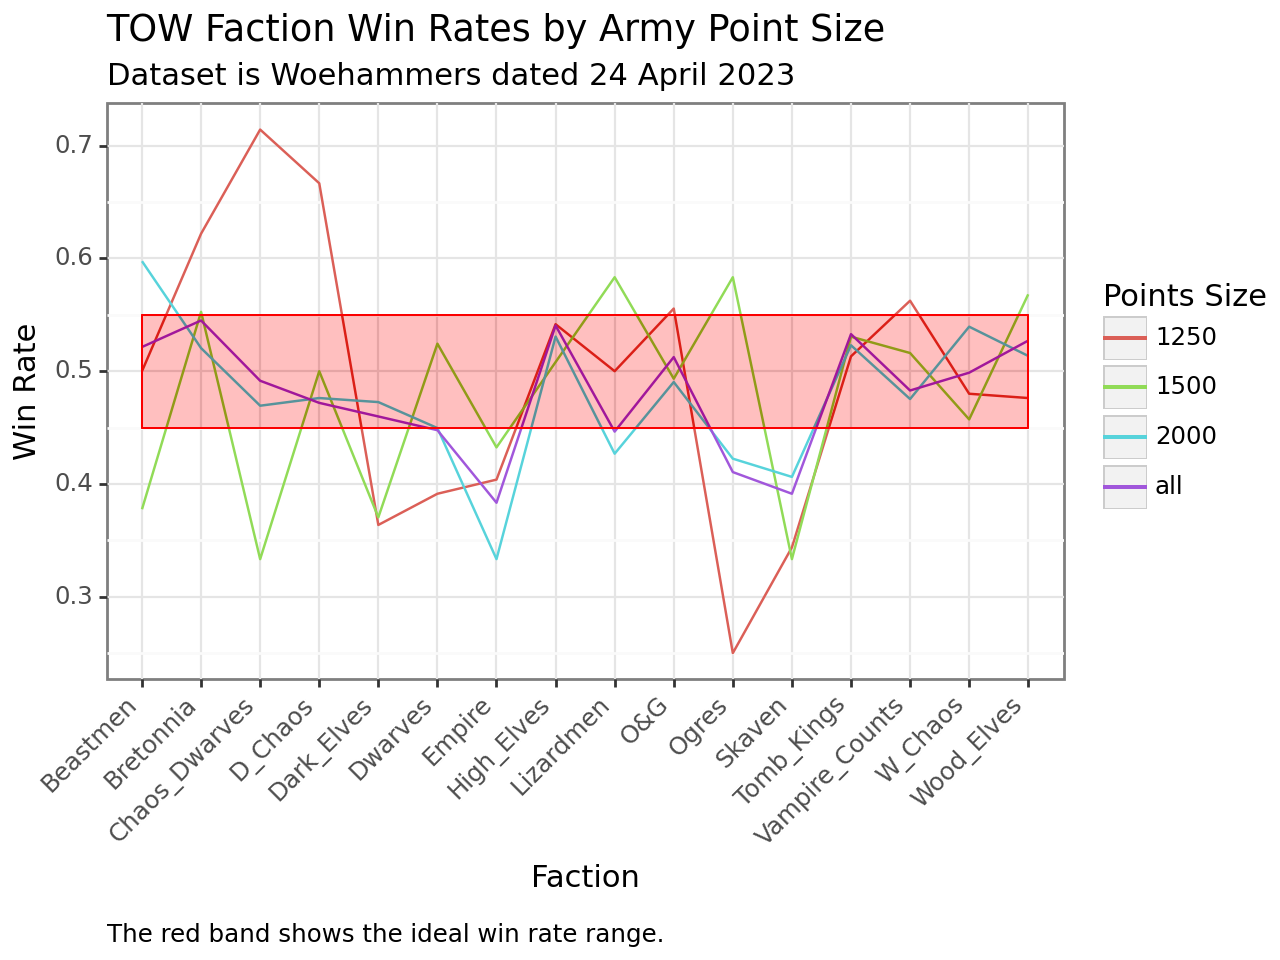

<Figure Size: (640 x 480)>

In [11]:
filter_list = ['all', '2000', '1500', '1250']
tow_plot = tow_points_wr.query("points == @filter_list")
(
    ggplot(tow_plot, aes(x='player_faction', y='win_rate', group='points', color='points'))
    + geom_line()
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}))
    + labs(title='TOW Faction Win Rates by Army Point Size', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Points Size', caption="The red band shows the ideal win rate range.")
)

So some initial observation: the 2000 points line follows our baseline pretty closely. This makes sense as the 2000 point size makes up the bulk of the dataset. The 1500 and 1250 point sizes show a lot of variance from the baseline, especially with the Chaos Dwarves and Ogres. The Empire, High Elves, Orcs & Goblins, Skaven, Tomb Kings, Vampire Counts, and Warriors of Chaos all look to be very consistent.

Now we can move into the regression analysis. We will use Ordinary Least Squares from the statsmodel package. This package will handle creating dummy variables for any categorical variable. 

In [12]:
formula = 'win_rate ~ player_faction + points'
model_df = tow_points_wr.query("points != 'all'")
mod = smf.ols(formula, model_df).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1.497
Date:                Wed, 19 Jun 2024   Prob (F-statistic):             0.0984
Time:                        07:58:07   Log-Likelihood:                 57.972
No. Observations:                  99   AIC:                            -67.94
Df Residuals:                      75   BIC:                            -5.662
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5623      0.085      6.620      0.000       0.393       0.731
player_faction[T.Bretonnia]          0.0151      0.090      0.167      0.868      -0.164       0.195
player_faction[T.Chaos_Dwarves]     -0.0126      0.114     -0.110      0.912      -0.240       0.215
player_faction[T.D_Chaos]           -0.0638      0.099     -0.646      0.521      -0.261       0.133
player_faction[T.Dark_Elves]        -0.0132      0.090     -0.147      0.884      -0.192       0.166
player_faction[T.Dwarves]           -0.1493      0.094     -1.587      0.117      -0.337       0.038
player_faction[T.Empire]            -0.0569      0.093     -0.612      0.543      -0.242       0.128
player_faction[T.High_Elves]         0.0725      0.092      0.792      0.431      -0.110       0.255
player_faction[T.Lizardmen]         -0.0474      0.095     -0.498      0.620      -0.237       0.142
player_faction[T.O&G]                0.0243      0.094      0.258      0.797      -0.163       0.212
player_faction[T.Ogres]             -0.0820      0.098     -0.837      0.405      -0.277       0.113
player_faction[T.Skaven]            -0.1779      0.100     -1.774      0.080      -0.378       0.022
player_faction[T.Tomb_Kings]         0.0412      0.092      0.450      0.654      -0.141       0.224
player_faction[T.Vampire_Counts]    -0.0151      0.094     -0.161      0.873      -0.203       0.172
player_faction[T.W_Chaos]           -0.0989      0.090     -1.103      0.274      -0.278       0.080
player_faction[T.Wood_Elves]         0.0036      0.092      0.039      0.969      -0.179       0.186
points[T.1250]                      -0.0345      0.060     -0.574      0.568      -0.154       0.085
points[T.1500]                      -0.0483      0.060     -0.803      0.424      -0.168       0.071
points[T.1750]                      -0.0461      0.066     -0.699      0.487      -0.177       0.085
points[T.1999]                      -0.0510      0.061     -0.842      0.403      -0.172       0.070
points[T.2000]                      -0.0493      0.060     -0.821      0.414      -0.169       0.070
points[T.2250]                       0.2111      0.093      2.276      0.026       0.026       0.396
points[T.2500]                       0.0540      0.079      0.680      0.499      -0.104       0.212
points[T.500]                        0.1776      0.107      1.666      0.100      -0.035       0.390
==============================================================================
Omnibus:                        5.932   Durbin-Watson:                   2.423
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                6.547
Skew:                           0.335   Prob(JB):                       0.0379
Kurtosis:                       4.066   

The OLS model is not significant (Probability of F-statistic >= 0.05) and is not predictive (Adjusted R-Squared). There is only one statistically significant variable (points[T.2250]) but that only has ten samples.

We can run an Analysis of Variance (ANOVA) to see if player_faction and/or points are significant.

In [13]:
table = sm.stats.anova_lm(mod, typ=2)
table

,sum_sq,df,F,PR(>F)
player_faction,0.408199,15.0,1.135817,0.340985
points,0.372747,8.0,1.944697,0.065506
Residual,1.796941,75.0,NaN,NaN


The ANOVA is showing that neither of our variables are statistically significant. Lastly, we can conduct a pairwise analysis to see which matchups are the most significant. We will adjust for multiple comparisons using the Holm-Sidak method.

In [14]:
pw = mod.t_test_pairwise("player_faction")
pw.result_frame[pw.result_frame["P>|t|"] <= 0.05]

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Skaven-Bretonnia,-0.192930,0.089754,-2.149535,0.034817,-0.371730,-0.014130,0.983605,False
High_Elves-Dwarves,0.221838,0.086669,2.559610,0.012492,0.049185,0.394491,0.775959,False
Tomb_Kings-Dwarves,0.190542,0.086669,2.198514,0.030997,0.017889,0.363195,0.974878,False
Skaven-High_Elves,-0.250371,0.093803,-2.669110,0.009318,-0.437236,-0.063505,0.674811,False
W_Chaos-High_Elves,-0.171427,0.080782,-2.122099,0.037132,-0.332352,-0.010501,0.987112,False
Skaven-O&G,-0.202172,0.096416,-2.096857,0.039378,-0.394243,-0.010100,0.989743,False
Tomb_Kings-Skaven,0.219075,0.093803,2.335478,0.022195,0.032210,0.405940,0.929241,False


The statistically significant pairwise tests have the Skaven showing up on the wrong side four times, with Dwarves at two. This aligns with what the previously shown graphic of win rates where the Skaven faction was well below the rest of the factions. 

### Win Rate by Rounds

So now we will do the same analysis as before, but this time looking at the faction win rates when controlling for the number of rounds during a tournament. The prevailing belief is that three-day tournaments (or five rounds) is where the top level players show through. So we want to see if the win rate during five-round tournaments are statistically different from the overall win rates.

In [15]:
player_db.groupby(['rounds'])['player_faction'].count().sort_values(ascending=False).reset_index()

,rounds,player_faction
0,3,2416
1,5,788
2,1,28


So there are three levels of tournament rounds: one, three, and five. We have more than triple the samples of three-round compared to five-round and not even thirty samples of one-round tournaments (these will be dropped from the model during variable selection).

In [16]:
tow_rounds_wr = player_db.groupby(['player_faction', 'rounds'])['opponent_faction'].count().reset_index()
tow_rounds_wins = player_db.query("result != 0.0").groupby(['player_faction', 'rounds'])['result'].sum().reset_index()
tow_rounds_wr = tow_rounds_wr.merge(tow_rounds_wins, left_on=['player_faction', 'rounds'], right_on=['player_faction', 'rounds'], how='left')
tow_rounds_wr.rename(columns={'opponent_faction':'games_played', 'result':'wins'}, inplace=True)
tow_rounds_wr['win_rate'] = tow_rounds_wr['wins'] / tow_rounds_wr['games_played']
tow_rounds_wr = (pd.concat([tow_rounds_wr, tow_faction_wr.rename(columns={'points':'rounds'})], ignore_index=True).sort_values(by=['player_faction', 'rounds']).
                 dropna().reset_index(drop=True))
tow_rounds_wr['rounds'] = tow_rounds_wr['rounds'].astype(str)
tow_rounds_wr

,player_faction,rounds,games_played,wins,win_rate
0,Beastmen,1,2,0.0,0.000000
1,Beastmen,3,94,49.5,0.526596
2,Beastmen,5,67,35.5,0.529851
3,Beastmen,all,163,85.0,0.521472
4,Bretonnia,1,4,0.0,0.000000
...,...,...,...,...,...
57,W_Chaos,all,378,188.5,0.498677
58,Wood_Elves,1,1,0.0,0.000000
59,Wood_Elves,3,156,85.0,0.544872
60,Wood_Elves,5,64,31.5,0.492188


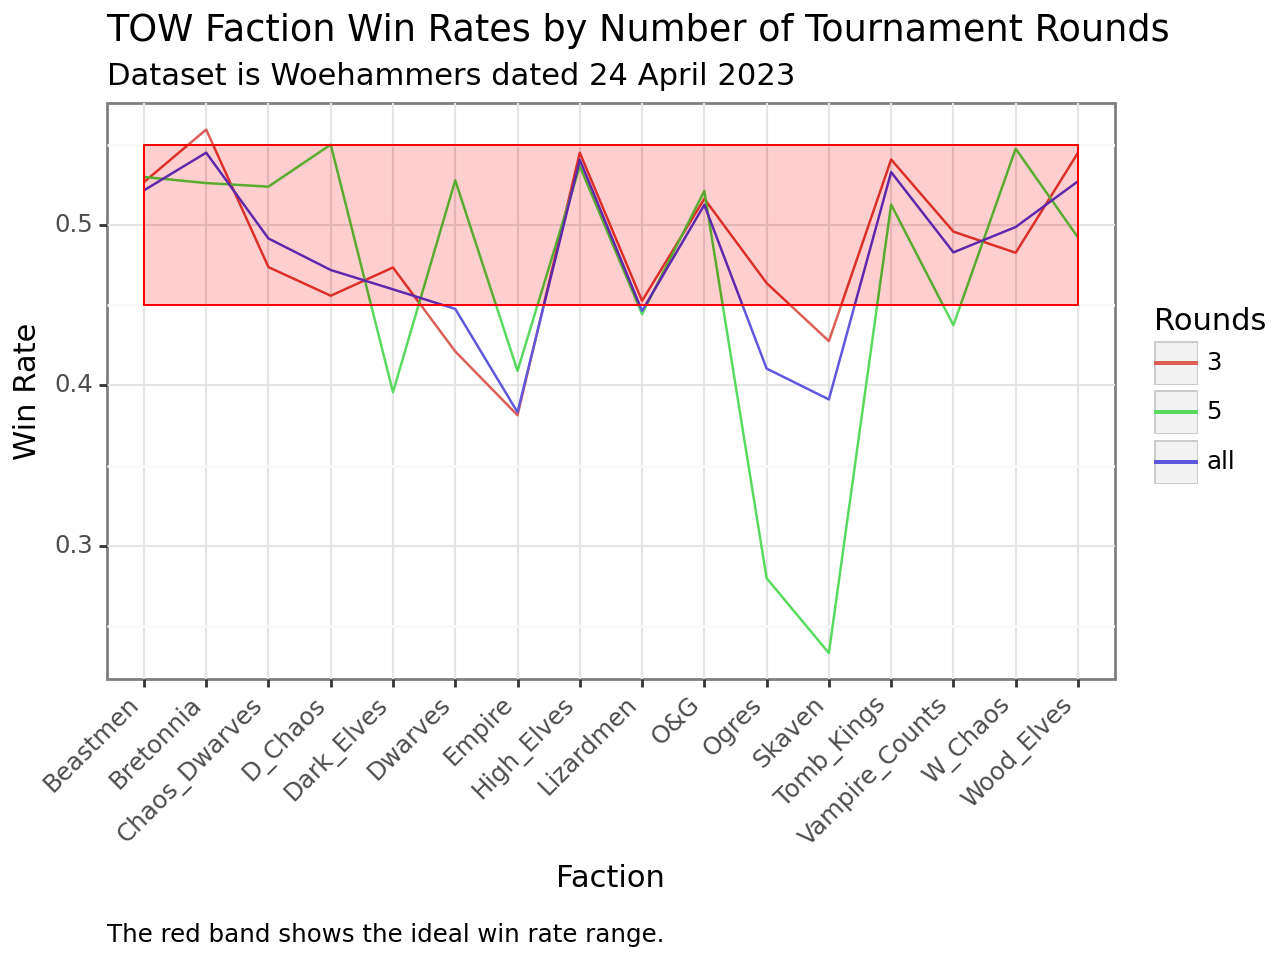

<Figure Size: (640 x 480)>

In [17]:
(
    ggplot(tow_rounds_wr.query("rounds != '1'"), aes(x='player_faction', y='win_rate', group='rounds', color='rounds'))
    + geom_line()
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}))
    + labs(title='TOW Faction Win Rates by Number of Tournament Rounds', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Rounds', caption="The red band shows the ideal win rate range.")
)

The chart is remarkably similar to the previous chart when controlling for points. We can see factions like Bretonnia, High Elves, and Tomb Kings all having similar win rates. So let's build a model and see what we have.

In [18]:
rounds_formula = 'win_rate ~ player_faction + rounds'
rounds_model = smf.ols(rounds_formula, tow_rounds_wr).fit()
rounds_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     24.70
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           5.26e-17
Time:                        07:58:07   Log-Likelihood:                 87.995
No. Observations:                  62   AIC:                            -138.0
Df Residuals:                      43   BIC:                            -97.57
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0717      0.039      1.852      0.071      -0.006       0.150
player_faction[T.Bretonnia]          0.0131      0.050      0.264      0.793      -0.087       0.113
player_faction[T.Chaos_Dwarves]     -0.0057      0.054     -0.106      0.916      -0.115       0.103
player_faction[T.D_Chaos]           -0.0250      0.050     -0.504      0.617      -0.125       0.075
player_faction[T.Dark_Elves]        -0.0590      0.054     -1.094      0.280      -0.168       0.050
player_faction[T.Dwarves]           -0.0453      0.050     -0.912      0.367      -0.146       0.055
player_faction[T.Empire]            -0.1010      0.050     -2.033      0.048      -0.201      -0.001
player_faction[T.High_Elves]         0.0944      0.050      1.899      0.064      -0.006       0.195
player_faction[T.Lizardmen]         -0.0586      0.050     -1.179      0.245      -0.159       0.042
player_faction[T.O&G]               -0.0070      0.050     -0.141      0.889      -0.107       0.093
player_faction[T.Ogres]             -0.1059      0.050     -2.131      0.039      -0.206      -0.006
player_faction[T.Skaven]            -0.1314      0.050     -2.644      0.011      -0.232      -0.031
player_faction[T.Tomb_Kings]         0.0021      0.050      0.042      0.967      -0.098       0.102
player_faction[T.Vampire_Counts]     0.0429      0.050      0.863      0.393      -0.057       0.143
player_faction[T.W_Chaos]           -0.0123      0.050     -0.248      0.806      -0.113       0.088
player_faction[T.Wood_Elves]        -0.0034      0.050     -0.069      0.945      -0.104       0.097
rounds[T.3]                          0.4385      0.026     16.861      0.000       0.386       0.491
rounds[T.5]                          0.4201      0.026     16.156      0.000       0.368       0.473
rounds[T.all]                        0.4324      0.026     16.627      0.000       0.380       0.485
==============================================================================
Omnibus:                       14.158   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.543
Skew:                           0.796   Prob(JB):                     2.10e-05
Kurtosis:                       5.409   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is both a strong fit (R-squared close to 1.0), statistically significant (Prob(F-statistic) <= 0.5), and predictive (Adjust R-squared close to 1.0). We have three variables (Empire, Ogres, and Skaven) that are significant with negative coefficients which aligns with their win rates being less than 45%.

In [19]:
rounds_table = sm.stats.anova_lm(rounds_model, typ=2)
rounds_table

,sum_sq,df,F,PR(>F)
player_faction,0.195811,15.0,2.642760,6.465047e-03
rounds,1.947261,3.0,131.406072,1.120112e-21
Residual,0.212401,43.0,NaN,NaN


The ANOVA confirms that both player_faction and rounds are significant. Lastly, the pairwise test.

In [20]:
rounds_pw = rounds_model.t_test_pairwise("rounds")
rounds_pw.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
3-1,0.438473,0.026005,16.861245,1.445456e-20,0.386029,0.490916,8.672739e-20,True
5-1,0.420142,0.026005,16.156339,7.098546e-20,0.367698,0.472585,2.839418e-19,True
all-1,0.432389,0.026005,16.627287,2.437845e-20,0.379945,0.484832,1.218922e-19,True
5-3,-0.018331,0.024848,-0.737709,4.646982e-01,-0.068443,0.031781,8.466103e-01,False
all-3,-0.006084,0.024848,-0.244846,8.077407e-01,-0.056196,0.044028,8.590873e-01,False
all-5,0.012247,0.024848,0.492864,6.246165e-01,-0.037865,0.062358,8.590873e-01,False


The pairwise test shows that there is a statistically significant difference between five-round tournament win rates and all win rates.

## Summary

So the two main takeways from this analysis are:
* The point size of an army has no significant effect on the armies overall win rate
* There is a statistically significant difference between the win rates of armies depending on the length of a tournament.

This second observation is of particular interest. While there is a difference, it is slight and either in favor of total win rate or the three round tournaments. This would imply that it is, in fact, more difficult to win during a five-round tournament. However, it affects most factions equally. The only factions that were significant in the regression model were Empire, Skaven, and Ogres, all with negative coefficients which holds the theme that those three factions continually underperformed.

## Future Work

My intent is to keep up this work as Woehammer releases their updated datasets to see how/if the trends change over time. I intend to also look at the win rates by FAQ/Errata releases. My long term goal is to parse the actual army lists (if possible) and conduct a comparison analysis to see which units are most frequently used and which units are most valuable.